# Pairs trading

The pairs trading thesis explored here is simple: Bitcoin is the genesis crypto currency, our goal is to find out whether there is any tradable pairs relationship between BTC and all other coins. Visually it seems like this would be the case.

In [15]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
mpl.style.use('bmh')
import pandas_datareader.data as web
import matplotlib.pylab as plt
from datetime import datetime
import statsmodels.api as sm
from pykalman import KalmanFilter
from math import sqrt
from hurst import compute_Hc
import backtrader as bt
import datetime
import warnings

In [2]:
main_df = pd.DataFrame()
coins = ['AAVE', 'ADA', 'ATOM', 'AVAX', 'AXS', 'BNB', 'BTC', 'CRV', 'DOGE', 
        'DOT', 'EOS', 'ETC', 'ETH', 'FIL', 'FTM', 'LINK', 'LTC', 'MATIC', 
        'NEAR', 'SOL', 'TRX', 'WAVES', 'XRP', 'ZIL', 'SUSHI', 'COMP', 'GRT', 
        'KNC', 'LRC', 'UNI', 'ENJ', 'ALGO', 'HNT', 'ZEC', 'KAVA', 'THETA', 'XMR', 
        'BAND', '1INCH', 'BAL', 'BAT', 'BEL', 'BLZ', 'CTK', 'DASH', 'DEFI', 
        'EGLD', 'FLM', 'ICX', 'IOST', 'IOTA', 'MKR', 'NEO', 'OMG', 'ONT', 
        'QTUM', 'REN', 'RSR', 'RUNE', 'SKL', 'STORJ', 'SXP', 'TRB', 'VET', 
        'XTZ', 'YFI', 'ZEN', 'ZRX']


for coin in coins:
    print(coin)
    dataset = f'C:/Users/spenc/Desktop/Prop trading firm/Neural networks/Crypto data/Binance/{coin}USDT_Binance_futures_UM_day.csv'
    df = pd.read_csv(dataset, usecols=['Date', 'Close'])  # read in specific file

    df.rename(columns={'Close': f'{coin}'}, inplace=True)
    df['Date'] = pd.to_datetime(df['Date'], infer_datetime_format=True)
    df.set_index('Date', inplace=True)
    
    df = df.sort_index()
    if len(main_df)==0:  
        main_df = df  
    else:  
        main_df = main_df.join(df, on='Date', how='left')

main_df.fillna(method='ffill', inplace=True)
main_df.dropna(inplace=True)

AAVE
ADA
ATOM
AVAX
AXS
BNB
BTC
CRV
DOGE
DOT
EOS
ETC
ETH
FIL
FTM
LINK
LTC
MATIC
NEAR
SOL
TRX
WAVES
XRP
ZIL
SUSHI
COMP
GRT
KNC
LRC
UNI
ENJ
ALGO
HNT
ZEC
KAVA
THETA
XMR
BAND
1INCH
BAL
BAT
BEL
BLZ
CTK
DASH
DEFI
EGLD
FLM
ICX
IOST
IOTA
MKR
NEO
OMG
ONT
QTUM
REN
RSR
RUNE
SKL
STORJ
SXP
TRB
VET
XTZ
YFI
ZEN
ZRX


In [3]:
main_df

,AAVE,ADA,ATOM,AVAX,AXS,BNB,BTC,CRV,DOGE,DOT,...,RUNE,SKL,STORJ,SXP,TRB,VET,XTZ,YFI,ZEN,ZRX
Date,,,,,,,,,,,,,,,,,,,,,
2020-12-25,79.742,0.15773,4.907,2.9534,0.60116,33.231,24730.00,0.488,0.004565,5.212,...,0.9248,0.09006,0.3007,0.7105,18.179,0.014605,2.028,23624.0,11.237,0.3590
2020-12-26,75.212,0.15856,4.812,2.9265,0.57926,33.638,26508.83,0.470,0.004519,5.193,...,0.8757,0.09098,0.2949,0.6902,17.211,0.016484,1.979,22606.3,11.924,0.3548
2020-12-27,76.919,0.15481,4.848,2.9100,0.60047,33.676,26305.64,0.472,0.004554,5.149,...,0.8984,0.08942,0.2979,0.6714,17.815,0.016553,2.008,22809.6,12.590,0.3743
2020-12-28,81.887,0.17663,5.397,2.9646,0.59982,36.026,27102.66,0.499,0.004609,6.608,...,1.0395,0.08762,0.3125,0.6723,19.899,0.020224,2.124,22829.1,12.205,0.3778
2020-12-29,78.169,0.19100,5.627,2.9253,0.56334,39.122,27402.83,0.473,0.004498,7.554,...,1.2014,0.08070,0.2987,0.6404,18.228,0.021263,2.046,22200.8,11.606,0.3666
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-27,57.430,0.26020,9.210,11.6410,6.70200,246.520,16698.20,0.529,0.073680,4.476,...,1.3800,0.02217,0.2607,0.2155,12.960,0.015970,0.772,5505.0,9.152,0.1607
2022-12-28,53.710,0.24800,9.129,11.2040,6.27800,244.420,16539.00,0.508,0.070340,4.284,...,1.3160,0.02128,0.2510,0.2103,11.860,0.015630,0.737,5230.0,8.869,0.1536
2022-12-29,54.410,0.24360,9.326,10.9670,6.16500,246.120,16630.30,0.510,0.070890,4.305,...,1.2990,0.02067,0.2487,0.2035,12.050,0.015690,0.737,5163.0,8.904,0.1533


<AxesSubplot:xlabel='Date'>

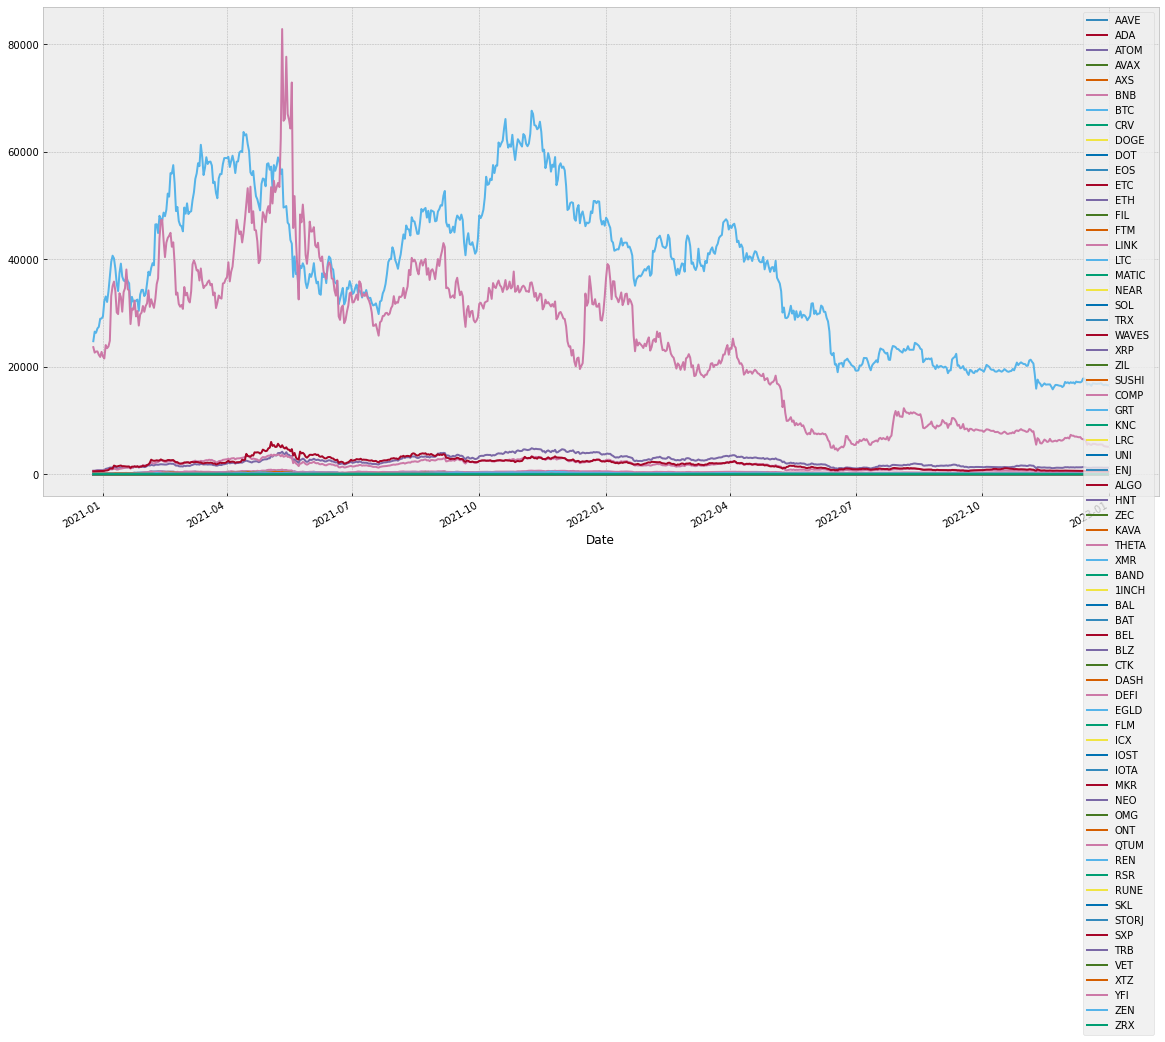

In [4]:
main_df.plot(figsize=(20,10))

Pairing up every coin with BTC to see if we have any cointegrating pairs. We are not going to put critical value restrictions in place, as we want to purely explore the thesis without relying on CADF testing.

In [5]:
def find_cointegrated_pairs_btc(df, critial_level = 1):
    n = df.shape[1] 
    pvalue_matrix = np.ones((n, n)) 
    keys = df.columns 
    pairs = [] 
    for i in range(n):
        if keys[i] == 'BTC':
            pass
        else:
            coin1 = df['BTC'] 
            coin2 = df[keys[i]]
            result = sm.tsa.stattools.coint(coin1, coin2) 
            pvalue = result[1] 
            if pvalue < critial_level: 
                pairs.append(('BTC', keys[i], pvalue))
                
    return pvalue_matrix, pairs

In [6]:
split = int(len(main_df) * 0.5)
pvalue_matrix, pairs = find_cointegrated_pairs_btc(main_df[:split])

In [7]:
for pair in pairs:
    print("Coin {} and Coin {} has a co-integration score of {}".format(pair[0],pair[1],round(pair[2],4)))

Coin BTC and Coin AAVE has a co-integration score of 0.5783
Coin BTC and Coin ADA has a co-integration score of 0.5267
Coin BTC and Coin ATOM has a co-integration score of 0.2403
Coin BTC and Coin AVAX has a co-integration score of 0.3539
Coin BTC and Coin AXS has a co-integration score of 0.3416
Coin BTC and Coin BNB has a co-integration score of 0.5031
Coin BTC and Coin CRV has a co-integration score of 0.4078
Coin BTC and Coin DOGE has a co-integration score of 0.3804
Coin BTC and Coin DOT has a co-integration score of 0.0112
Coin BTC and Coin EOS has a co-integration score of 0.4584
Coin BTC and Coin ETC has a co-integration score of 0.3695
Coin BTC and Coin ETH has a co-integration score of 0.598
Coin BTC and Coin FIL has a co-integration score of 0.4271
Coin BTC and Coin FTM has a co-integration score of 0.2405
Coin BTC and Coin LINK has a co-integration score of 0.5858
Coin BTC and Coin LTC has a co-integration score of 0.4352
Coin BTC and Coin MATIC has a co-integration score o

In [8]:
def KalmanFilterAverage(x):
  # Construct a Kalman filter
    kf = KalmanFilter(transition_matrices = [1],
    observation_matrices = [1],
    initial_state_mean = 0,
    initial_state_covariance = 1,
    observation_covariance=1,
    transition_covariance=.01)
  # Use the observed values of the price to get a rolling mean
    state_means, _ = kf.filter(x.values)
    state_means = pd.Series(state_means.flatten(), index=x.index)
    return state_means
# Kalman filter regression
def KalmanFilterRegression(x,y):
    delta = 1e-3
    trans_cov = delta / (1 - delta) * np.eye(2) # How much random walk wiggles
    obs_mat = np.expand_dims(np.vstack([[x], [np.ones(len(x))]]).T, axis=1)
    kf = KalmanFilter(n_dim_obs=1, n_dim_state=2, # y is 1-dimensional, (alpha, beta) is 2-dimensional
    initial_state_mean=[0,0],
    initial_state_covariance=np.ones((2, 2)),
    transition_matrices=np.eye(2),
    observation_matrices=obs_mat,
    observation_covariance=2,
    transition_covariance=trans_cov)
    # Use the observations y to get running estimates and errors for the state parameters
    state_means, state_covs = kf.filter(y.values)
    return state_means
def half_life(spread):
    spread_lag = spread.shift(1)
    spread_lag.iloc[0] = spread_lag.iloc[1]
    spread_ret = spread - spread_lag
    spread_ret.iloc[0] = spread_ret.iloc[1]
    spread_lag2 = sm.add_constant(spread_lag)
    model = sm.OLS(spread_ret,spread_lag2)
    res = model.fit()
    halflife = int(round(-np.log(2) / res.params[1],0))
    if halflife <= 0:
        halflife = 1
    return halflife

In [9]:
def get_hist_halflife(df, s1, s2):
    x = df[s1]
    y = df[s2]
    # run regression (including Kalman Filter) to find hedge ratio and then create spread series
    df1 = pd.DataFrame({'y':y,'x':x})
    df1.index = pd.to_datetime(df1.index)
    state_means = KalmanFilterRegression(KalmanFilterAverage(x),KalmanFilterAverage(y))
    df1['hr'] = - state_means[:,0]
    df1['spread'] = df1.y + (df1.x * df1.hr)
    # calculate half life
    halflife = half_life(df1['spread'])
    
    return halflife

The testing below is theoretical, a more comprehensive backtest will have to be performed with more realistic fee calculations.

In [10]:
def backtest(df,s1, s2, halflife):
    x = df[s1]
    y = df[s2]
    # run regression (including Kalman Filter) to find hedge ratio and then create spread series
    df1 = pd.DataFrame({'y':y,'x':x})
    df1.index = pd.to_datetime(df1.index)
    state_means = KalmanFilterRegression(KalmanFilterAverage(x),KalmanFilterAverage(y))
    df1['hr'] = - state_means[:,0]
    df1['spread'] = df1.y + (df1.x * df1.hr)
    # this is the historical half-life calculated on the training set
    df1['halflife'] = halflife
    # calculate z-score with window = half life period
    meanSpread = df1.spread.rolling(window=halflife).mean()
    stdSpread = df1.spread.rolling(window=halflife).std()
    df1['zScore'] = (df1.spread-meanSpread)/stdSpread
    ##############################################################
    # trading logic
    entryZscore = 1.5
    exitZscore = 0
    #set up num units long
    df1['long entry'] = ((df1.zScore < - entryZscore) & ( df1.zScore.shift(1) > - entryZscore))
    df1['long exit'] = ((df1.zScore > - exitZscore) & (df1.zScore.shift(1) < - exitZscore))
    df1['num units long'] = np.nan
    df1.loc[df1['long entry'],'num units long'] = 1 
    df1.loc[df1['long exit'],'num units long'] = 0 
    df1['num units long'][0] = 0 
    df1['num units long'] = df1['num units long'].fillna(method='pad') 
    #set up num units short 
    df1['short entry'] = ((df1.zScore > entryZscore) & ( df1.zScore.shift(1) < entryZscore))
    df1['short exit'] = ((df1.zScore < exitZscore) & (df1.zScore.shift(1) > exitZscore))
    df1.loc[df1['short entry'],'num units short'] = -1
    df1.loc[df1['short exit'],'num units short'] = 0
    df1['num units short'][0] = 0
    df1['num units short'] = df1['num units short'].fillna(method='pad')
    df1['numUnits'] = df1['num units long'] + df1['num units short'] 
    
    df1['fees'] = np.nan
    conditions = [(df1['long entry'] == True),  
                  (df1['short entry'] == True)]
    
    choices = [0.0016, 0.0016]
    df1['fees'] = np.select(conditions, choices, default=0)
    df1['fees'] = df1['fees'].shift(1)
    
        # creating a entry hedge ratio, hr fixed 
    numUnits = list(df1['numUnits'])
    hr = list(df1['hr'])
    entryhr = [0] * len(hr)
    
    for i in range(1, len(hr)):  
        
        if numUnits[i] != numUnits[i - 1]:
            entryhr[i] = hr[i]
        else:
            entryhr[i] = entryhr[i-1]
    
    df1['entryhr'] = entryhr
    
    df1['spread pct ch'] = (df1['spread'] - df1['spread'].shift(1)) / ((df1['x'] * abs(df1['entryhr'])) + df1['y'])
    df1['port rets'] = df1['spread pct ch'] * df1['numUnits'].shift(1) - df1['fees']
    df1['port rets + 1'] = df1['port rets'] + 1
    df1['cum rets'] = df1['port rets + 1'].cumprod()
    
    ##############################################################
    try:
        sharpe = ((df1['port rets'].mean() / df1['port rets'].std()) * sqrt(365))
    except ZeroDivisionError:
        sharpe = 0.0
    ##############################################################
    start_val = 1
    end_val = df1['cum rets'].iat[-1]
    start_date = df1.iloc[0].name
    end_date = df1.iloc[-1].name
    days = (end_date - start_date).days
    try:
        CAGR = round(((float(end_val) / float(start_val)) ** (365/days)) - 1,4)
    except TypeError:
        CAGR = 0.0
    df1[s1+ " "+s2] = df1['cum rets']
    return df1[s1+" "+s2], sharpe, CAGR

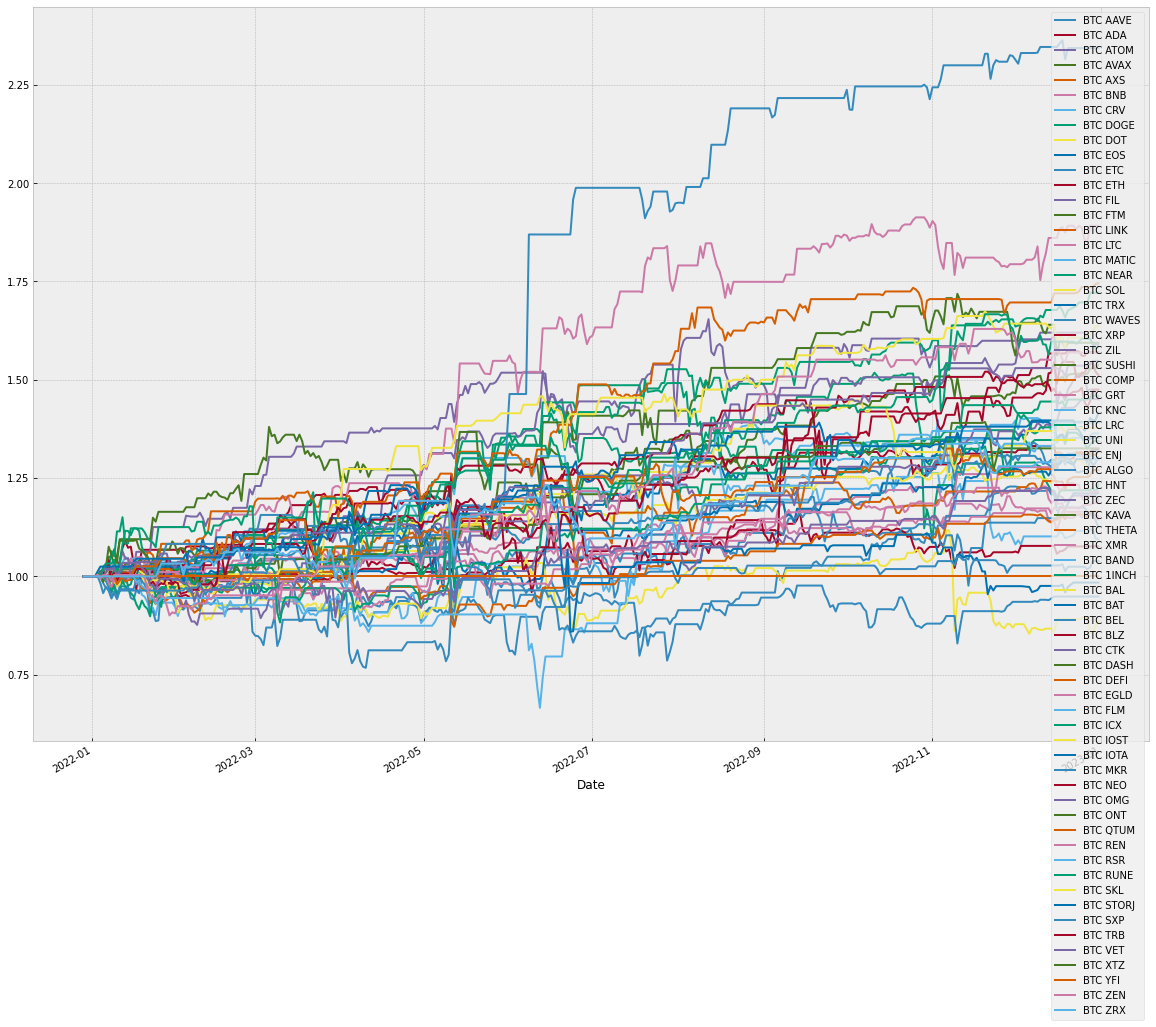

In [17]:
warnings.filterwarnings('ignore')

results = []

for pair in pairs:
    halflife = get_hist_halflife(main_df[:split],pair[0],pair[1])
    rets, sharpe,  CAGR = backtest(main_df[split:],pair[0],pair[1], halflife)
    results.append(rets)
#     print("The pair {} and {} produced a Sharpe Ratio of {} and a CAGR of {}".format(pair[0],pair[1],round(sharpe,2),round(CAGR,4)))
    rets.plot(figsize=(20,15),legend=True)

<AxesSubplot:title={'center':'Equity Curve'}, xlabel='Date', ylabel='Equity'>

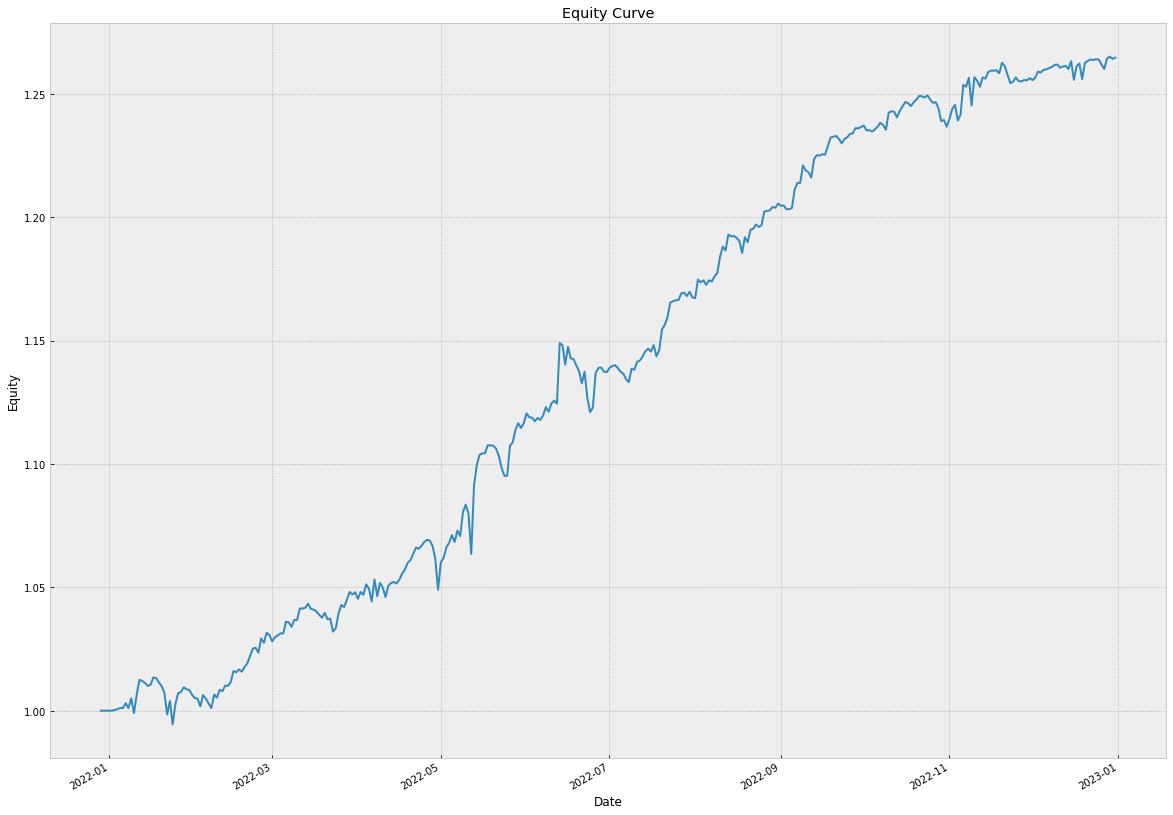

In [18]:
results_df = pd.concat(results,axis=1).dropna()
results_df /= len(results_df.columns)
final_res = results_df.sum(axis=1)
final_res.plot(figsize=(20,15), ylabel='Equity', title='Equity Curve')

In [19]:
#calculate and print our some final stats for our combined equity curve
sharpe = (final_res.pct_change().mean() / final_res.pct_change().std()) * (sqrt(365))
start_val = 1
end_val = final_res.iloc[-1]
start_date = final_res.index[0]
end_date = final_res.index[-1]
days = (end_date - start_date).days
CAGR = round(((float(end_val) / float(start_val)) ** (365.0/days)) - 1,4)
print("Sharpe Ratio is {} and CAGR is {}".format(round(sharpe,2),round(CAGR,4)))

Sharpe Ratio is 3.46 and CAGR is 0.263


#### Strategy improvements

1. Scaling in. Scale in as spread deviates more from the mean. Scale in at 1, 2 and 3 standard deviation points.

2. Machine learning for trade profitability expectation. Simply compute the probability that a trade will be profitable (random forest or xgboost would be sufficient). Or machine learning for predicting trade outcome when entering trade and during the trade lifecycle (neural network).

3. Dynamic halflife updates.

4. Size bets and adjust leverage using the kelly criterion, relying on historical data.

5. Machine learning to estimate the kelly criterion more accurately. 